
Training with batch size: 32
Sharpness for batch size 32: 1.4469027519226074e-05

Training with batch size: 64
Sharpness for batch size 64: 4.474073648452759e-06

Training with batch size: 128
Sharpness for batch size 128: 3.509223461151123e-06

Training with batch size: 256
Sharpness for batch size 256: 8.337199687957764e-06

Training with batch size: 512
Sharpness for batch size 512: 9.119510650634766e-06

Training with batch size: 1024
Sharpness for batch size 1024: 7.18235969543457e-06

Training with batch size: 2048
Sharpness for batch size 2048: 6.22868537902832e-06

Training with batch size: 4096
Sharpness for batch size 4096: 1.3053417205810547e-05

Training with batch size: 8192
Sharpness for batch size 8192: 6.556510925292969e-06


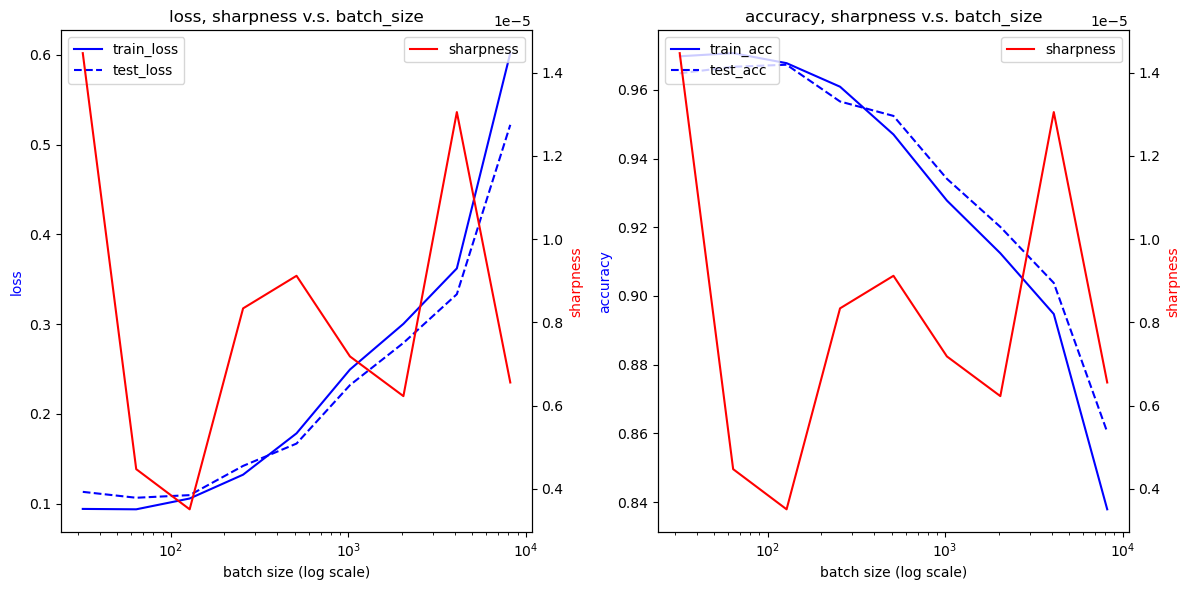

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=data_transforms)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network model
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Simplified sharpness calculation
def sharpness_measure(model, loss_func, data_loader, epsilon=1e-5):
    model.eval()
    data_iter = iter(data_loader)
    inputs, labels = next(data_iter)
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    loss = loss_func(outputs, labels)

    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grad_norm = torch.sqrt(sum(torch.sum(g ** 2) for g in grads))

    with torch.no_grad():
        for param, grad in zip(model.parameters(), grads):
            param += epsilon * grad / (grad_norm + 1e-10)

    outputs_perturbed = model(inputs)
    loss_perturbed = loss_func(outputs_perturbed, labels)

    sharpness = (loss_perturbed - loss).item()

    with torch.no_grad():
        for param, grad in zip(model.parameters(), grads):
            param -= epsilon * grad / (grad_norm + 1e-10)

    return sharpness

# Training function
def train_model(model, train_loader, test_loader, optimizer, loss_func, epochs):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(correct_train / total_train)

        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, predicted_test = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()

        avg_test_loss = running_test_loss / len(test_loader.dataset)
        test_loss_history.append(avg_test_loss)
        test_acc_history.append(correct_test / total_test)

    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

# Set different batch sizes for comparison
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# Dictionary to store sharpness, train/test loss, and accuracy for each batch size
sharpness_dict = {}
train_loss_dict = {}
test_loss_dict = {}
train_acc_dict = {}
test_acc_dict = {}

# Training with different batch sizes and calculating sharpness, loss, and accuracy
for bs in batch_sizes:
    print(f"\nTraining with batch size: {bs}")
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=bs, shuffle=False)
    
    # Initialize model and optimizer
    model = MLPModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_func = nn.CrossEntropyLoss()
    
    # Train the model for 5 epochs
    train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, test_loader, optimizer, loss_func, epochs=5)
    
    # Calculate sharpness
    sharpness = sharpness_measure(model, loss_func, test_loader)
    sharpness_dict[bs] = sharpness
    train_loss_dict[bs] = train_loss[-1]
    test_loss_dict[bs] = test_loss[-1]
    train_acc_dict[bs] = train_acc[-1]
    test_acc_dict[bs] = test_acc[-1]
    print(f"Sharpness for batch size {bs}: {sharpness}")

# Plotting loss, accuracy, and sharpness vs batch size
batch_sizes_log = [np.log10(bs) for bs in batch_sizes]

# Create a figure with two subplots (one for loss, one for accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Loss and Sharpness vs Batch Size
ax1.plot(batch_sizes, list(train_loss_dict.values()), 'b-', label='train_loss')
ax1.plot(batch_sizes, list(test_loss_dict.values()), 'b--', label='test_loss')
ax1.set_xscale('log')
ax1.set_xlabel('batch size (log scale)')
ax1.set_ylabel('loss', color='blue')

ax3 = ax1.twinx()  
ax3.plot(batch_sizes, list(sharpness_dict.values()), 'r-', label='sharpness')
ax3.set_ylabel('sharpness', color='red')

ax1.legend(loc='upper left')
ax3.legend(loc='upper right')
ax1.set_title('loss, sharpness v.s. batch_size')

# Plot 2: Accuracy and Sharpness vs Batch Size
ax2.plot(batch_sizes, list(train_acc_dict.values()), 'b-', label='train_acc')
ax2.plot(batch_sizes, list(test_acc_dict.values()), 'b--', label='test_acc')
ax2.set_xscale('log')
ax2.set_xlabel('batch size (log scale)')
ax2.set_ylabel('accuracy', color='blue')

ax4 = ax2.twinx()  
ax4.plot(batch_sizes, list(sharpness_dict.values()), 'r-', label='sharpness')
ax4.set_ylabel('sharpness', color='red')

ax2.legend(loc='upper left')
ax4.legend(loc='upper right')
ax2.set_title('accuracy, sharpness v.s. batch_size')

plt.tight_layout()
plt.show()
